**[Implementation of Real-time Scene Text Detection with Differentiable Binarization](https://arxiv.org/pdf/1911.08947.pdf) with [FPGM Pruning](https://arxiv.org/pdf/1811.00250.pdf)**

**Tangentially Related Papers Worth Reading:** [DeformableConvNets](https://arxiv.org/pdf/1703.06211v3.pdf), [Deformable ConvNets v2](https://arxiv.org/pdf/1811.11168.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Environment Path Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH = './checkpoints/DBNet/'
OUTPUT_PATH = './outputs/DBNet'
DATASET = 'SynthText'

# Data Loading Constants
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = True

# Training Constants
BATCH_PRINT = 50
EPOCH_CHECKPOINT = 10
NUM_EPOCHS = 1000
IS_TRAINING = True

# Device Setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')

Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200


## Data Loading

Will be Using the Pre-Generated 800K Sample SynthText Dataset to pretrain our model.

**Reference:** [SynthText GitHub](https://github.com/ankush-me/SynthText), [Pre-Generated SynthText](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)

In [2]:
from dataset import SynthText
import torchvision.transforms as transforms
from torchvision.utils import make_grid

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

transform = transforms.Compose([
    transforms.ToTensor()
])

synth_text = SynthText(f'{DATASET_PATH}{DATASET}', transform=transform)

In [3]:
from torch.utils.data import DataLoader

# Have to define a collate_fn since this is a custom dataset with non-homogenous dimensions per sample.
def collate_fn(batch):
    
    return

synth_loader = DataLoader(synth_text, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)

In [4]:
x = next(iter(synth_loader))[0][:8]
show(img)

TypeError: 'NoneType' object is not subscriptable

## Label Generation

Need to convert bounding box labels from our dataset to ground truth probability maps and threshold maps in order to train our model. ( This is a segmentation based text detector not regression )

Using Vatti clipping algorithm where the offset D is:

$D = \dfrac{A(1-r^{2})}{L}$, $A$ is the area and $L$ is the perimeter of the original polygon

and $r$ is the shrink ratio, set to 0.4 empirically.

**Reference:** [Vatti Polygon Clipping](http://what-when-how.com/computer-graphics-and-geometric-modeling/clipping-basic-computer-graphics-part-5/), [PyClipper](http://www.angusj.com/delphi/clipper/documentation/Docs/Overview/_Body.htm)

[[420, 21], [512, 23], [511, 41], [420, 39]]
[[418, 46], [431, 48], [428, 68], [415, 66]]
[[448, 47], [519, 50], [518, 70], [447, 67]]
[[410, 73], [499, 77], [499, 98], [409, 95]]
[[117, 197], [179, 208], [172, 245], [110, 233]]
[[322, 9], [377, 8], [378, 30], [322, 31]]
[[322, 48], [376, 46], [377, 68], [323, 70]]
[[159, 9], [203, 9], [203, 32], [158, 31]]
[[154, 49], [193, 50], [193, 73], [153, 72]]
[[260, 208], [313, 203], [319, 264], [266, 269]]
[[431, 118], [487, 122], [485, 147], [430, 143]]
[[427, 162], [484, 168], [482, 189], [425, 184]]
[[296, 29], [365, 29], [365, 72], [296, 71]]
[[99, 5], [142, 6], [142, 22], [99, 22]]
[[108, 28], [144, 29], [144, 50], [108, 50]]
(1, 4, 2)


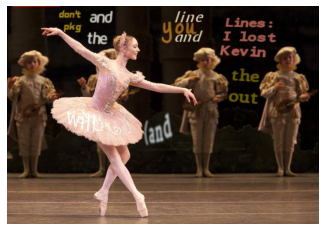

In [58]:
import pyclipper
import cv2

def plot_bb(x, bbox):
    c,h,w = x.shape
    m,n,o = bbox.shape
    x = (x*255).numpy().astype(np.uint8)
    subjects = []
    for i in range(o):
        bb = []
        for j in range(n):
            # Clockwise (x,y) -> (r,c) y coordinate flipped
            point = [int(bbox[0][j][i]), int(bbox[1][j][i])]
            bb.append(point)
        subjects.append(bb)
        print(bb)
        cv2.polylines(x, [np.array(bb, dtype=np.int32)], True, (255,155,0), 2)
    a = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32)
    print(a.shape)
    x = cv2.fillPoly(x, a,color=(255,255,255))
    plt.figure(frameon=False); plt.axis('off')
    plt.imshow(np.transpose(x, (1,2,0)))
    

def gen_label(x, bbox):
    print(x.shape, bbox.shape)
    c,h,w = x.shape
    m,n,o = bbox.shape
    pco = pyclipper.PyclipperOffset()
    subjects = []
    for i in range(o):
        bb = []
        for j in range(n):
            # Clockwise (x,y) -> (r,c) y coordinate flipped
            point = [int(bbox[1][j][i]), int(bbox[0][j][i])]
            bb.append(point)
        subjects.append(bb)
    
    pco.AddPath(subjects[0], pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
    solution = pco.Execute(-7.0)
    
    p_map = np.zeros_like(x)
    plt.figure()
    plt.axis('off')

    plt.imshow(np.transpose(p_map, (1,2,0)), interpolation='nearest')    
    print(subjects[0])
    #cv2.fillPoly(p_map, pts=[np.array([[0,0],[0,100],[100,100],[100,0]])], color=(0.5,0.5,0.5) )

    plt.figure()
    plt.axis('off')
    #contours = np.array([[50,50], [50,150], [150,150], [150,50]])
    #image = np.zeros((200,200))
    #cv2.fillPoly(image, pts = [contours], color =(255,255,255))

    plt.imshow(np.transpose(p_map, (1,2,0)), interpolation='nearest')
    return bbox, bbox

x,word_bb,_,_ = next(iter(synth_text))
plot_bb(x,word_bb)
#prob_map, thresh_map = gen_label(x, word_bb)

## Differentiable Binarization

$B_{i,j} = \dfrac{1}{1 + e^{-k(P_{i,j} - T_{i,j})}}$, where $k$ is an amplifying factor that is set to 50 empircally, $P_{i,j}$ is the probability map and $T_{i,j}$ is the threshold map.

In [13]:
class DifferentiableBinarization(nn.Module):
    def __init__(self, k):
        super(DifferentiableBinarization, self).__init__()
        self.k = k
        
    def forward(self, x, p, t):
        return x

## Backbone Architectures

## Model Definition
![Figure 3 from Paper](./images/dbnet_arch.png)

## Training

## FPGM Pruning